# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import configparser
import datetime
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, udf, col, min, max, when
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import SQLContext
import psycopg2
import boto3
import Cleaningdata

from Cleaningdata import clean_spark_Airbnb_data

In [2]:
config = configparser.ConfigParser()
config.read('dwh.cfg')

[]

In [ ]:
os.environ['AWS_ACCESS_KEY_ID']=config['keypair']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['keypair']['AWS_SECRET_ACCESS_KEY']

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

In [6]:
### Exploration

spark = SparkSession \
            .builder \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
            .getOrCreate()

fname_df = (spark.read.format('csv')
           .option('header', 'True')
           .option("inferSchema", "true")
           .load('airport-codes_csv.csv'))

In [7]:
# Read in the data here
fname = 'airport-codes_csv.csv'
fname2 = 'healthy_lifestyle_city_2021.csv'
fname3 = 'airbnb_csv.csv'
AirportCodes_df = pd.read_csv(fname)
Lifestyles_df = pd.read_csv(fname2)
Airbnb_df = pd.read_csv(fname3)


In [17]:
AirportCodes_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [11]:
AirportCodes_df.tail()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
55070,ZYYK,medium_airport,Yingkou Lanqi Airport,0.0,AS,CN,CN-21,Yingkou,ZYYK,YKH,NaN,"122.3586, 40.542524"
55071,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,"123.49600219726562, 41.784400939941406"
55072,ZZ-0001,heliport,Sealand Helipad,40.0,EU,GB,GB-ENG,Sealand,NaN,NaN,NaN,"1.4825, 51.894444"
55073,ZZ-0002,small_airport,Glorioso Islands Airstrip,11.0,AF,TF,TF-U-A,Grande Glorieuse,NaN,NaN,NaN,"47.296388888900005, -11.584277777799999"
55074,ZZZZ,small_airport,Satsuma IÅjima Airport,338.0,AS,JP,JP-46,Mishima-Mura,RJX7,NaN,NaN,"130.270556, 30.784722"


In [12]:

AirportCodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [13]:
###Check for Nulls

AirportCodes_df.isnull().any()

ident           False
type            False
name            False
elevation_ft     True
continent        True
iso_country      True
iso_region      False
municipality     True
gps_code         True
iata_code        True
local_code       True
coordinates     False
dtype: bool

In [14]:
### Check for Duplicate Values
AirportCodes_df.duplicated().any()

False

In [18]:
Lifestyles_df.head()

,City,Rank,Sunshine hours(City),Cost of a bottle of water(City),Obesity levels(Country),Life expectancy(years) (Country),Pollution(Index score) (City),Annual avg. hours worked,Happiness levels(Country),Outdoor activities(City),Number of take out places(City),Cost of a monthly gym membership(City)
0,Amsterdam,1,1858,£1.92,20.40%,81.2,30.93,1434,7.44,422,1048,£34.90
1,Sydney,2,2636,£1.48,29.00%,82.1,26.86,1712,7.22,406,1103,£41.66
2,Vienna,3,1884,£1.94,20.10%,81.0,17.33,1501,7.29,132,1008,£25.74
3,Stockholm,4,1821,£1.72,20.60%,81.8,19.63,1452,7.35,129,598,£37.31
4,Copenhagen,5,1630,£2.19,19.70%,79.8,21.24,1380,7.64,154,523,£32.53


In [19]:
Lifestyles_df.tail()

,City,Rank,Sunshine hours(City),Cost of a bottle of water(City),Obesity levels(Country),Life expectancy(years) (Country),Pollution(Index score) (City),Annual avg. hours worked,Happiness levels(Country),Outdoor activities(City),Number of take out places(City),Cost of a monthly gym membership(City)
39,Milan,40,1915,£1.15,19.90%,82.7,67.19,1718,6.38,110,2396,£53.49
40,"Washington, D.C.",41,2528,£1.45,36.20%,78.8,39.18,1779,6.94,83,744,£65.99
41,New York,42,2535,£1.32,36.20%,78.8,57.36,1779,6.94,359,3081,£64.66
42,Moscow,43,1901,£0.41,23.10%,69.5,57.63,1965,5.54,322,3206,£31.40
43,Mexico City,44,2555,£0.45,28.90%,76.4,82.78,2137,6.46,192,1313,£41.99


In [20]:
Lifestyles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 12 columns):
City                                      44 non-null object
Rank                                      44 non-null int64
Sunshine hours(City)                      44 non-null object
Cost of a bottle of water(City)           44 non-null object
Obesity levels(Country)                   44 non-null object
Life expectancy(years) (Country)          44 non-null float64
Pollution(Index score) (City)             44 non-null object
Annual avg. hours worked                  44 non-null object
Happiness levels(Country)                 44 non-null float64
Outdoor activities(City)                  44 non-null int64
Number of take out places(City)           44 non-null int64
Cost of a monthly gym membership(City)    44 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 4.2+ KB


In [21]:
### Check for Null values

Lifestyles_df.isnull().any()

City                                      False
Rank                                      False
Sunshine hours(City)                      False
Cost of a bottle of water(City)           False
Obesity levels(Country)                   False
Life expectancy(years) (Country)          False
Pollution(Index score) (City)             False
Annual avg. hours worked                  False
Happiness levels(Country)                 False
Outdoor activities(City)                  False
Number of take out places(City)           False
Cost of a monthly gym membership(City)    False
dtype: bool

In [22]:
####Check for duplicates

Lifestyles_df.duplicated().any()

False

In [23]:
Airbnb_df.head()

,Airbnb_id,City,State,Source,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Cross23,Los Angeles,CA,Airbnb for Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adam22,Los Angeles,CA,Airbnb Web Client,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JdaJerm,New York,NY,Airbnb for Iphone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SingleShulzy,Orlando,FL,Airbnb for Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Terminator3,Jackson,MS,Airbnb Web Client,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
Airbnb_df.tail()

,Airbnb_id,City,State,Source,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
25767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
Airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25772 entries, 0 to 25771
Data columns (total 12 columns):
Airbnb_id      15 non-null object
City           15 non-null object
State          15 non-null object
Source         15 non-null object
Unnamed: 4     0 non-null float64
Unnamed: 5     0 non-null float64
Unnamed: 6     0 non-null float64
Unnamed: 7     0 non-null float64
Unnamed: 8     0 non-null float64
Unnamed: 9     0 non-null float64
Unnamed: 10    0 non-null float64
Unnamed: 11    0 non-null float64
dtypes: float64(8), object(4)
memory usage: 2.4+ MB


In [27]:
### Check for Null Values

Airbnb_df.isnull().any()

Airbnb_id      True
City           True
State          True
Source         True
Unnamed: 4     True
Unnamed: 5     True
Unnamed: 6     True
Unnamed: 7     True
Unnamed: 8     True
Unnamed: 9     True
Unnamed: 10    True
Unnamed: 11    True
dtype: bool

In [28]:
####Check for duplicates

Airbnb_df.duplicated().any()

True

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

# Performing cleaning tasks here
### 1. Read in the data as done above
### 2. View first 5 rows of data as done above. 
### 3. Look at data's information as done above.
### 4. Check for any duplicates as done above
### 5. Check for any null values as done above. 



In [29]:
### 6. View ratio of missing values within Airport codes. Only .10 ratio for municipality and .13 ratio of missing values for elevation so we'll keep those rows. 

missing_avg_municipality = AirportCodes_df["municipality"].isnull().sum() / AirportCodes_df.shape[0]
missing_elevation = AirportCodes_df["elevation_ft"].isnull().sum() / AirportCodes_df.shape[0]
print(f"Ratio of missing values for municipality {missing_avg_municipality:.2f}")
print(f"Ratio of missing values for elevation_ft {missing_elevation:.2f}")

Ratio of missing values for municipality 0.10
Ratio of missing values for elevation_ft 0.13


### 7. Dimension before cleaning data

In [41]:
print(AirportCodes_df.shape)
AirportCodes_df.dropna(inplace=True)
print(AirportCodes_df.shape)

(55075, 12)
(678, 12)


### 8. Clean Airbnb Data Frame

In [8]:
new_airbnb_df = Cleaningdata.clean_spark_Airbnb_data

### 9. Drop Unnamed Columns

In [9]:

drop_columns = ['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11' ]
Airbnb_df = Airbnb_df.drop(columns=drop_columns)

### 10. Check to see if columns were removed. 

In [13]:
Airbnb_df

,Airbnb_id,City,State,Source
0,Cross23,Los Angeles,CA,Airbnb for Android
1,Adam22,Los Angeles,CA,Airbnb Web Client
2,JdaJerm,New York,NY,Airbnb for Iphone
3,SingleShulzy,Orlando,FL,Airbnb for Android
4,Terminator3,Jackson,MS,Airbnb Web Client
5,SantaClaus31,Detroit,MI,Airbnb for Iphone
6,LifeisFabolous,New York,NY,Airbnb for Android
7,TimeTravelorsHusband3,Los Angeles,CA,Airbnb Web Client
8,TheAnswer12,Tacoma,WA,Airbnb for Iphone
9,Cross23,Chicago,IL,Airbnb for Android


### 11. drop rows where all elements are missing

In [12]:
Airbnb_df = Airbnb_df.dropna(how='all')        

### 12. Check to See if all missing values were removed.

In [69]:
Airbnb_df

,Airbnb_id,City,State,Source
0,Cross23,Los Angeles,CA,Airbnb for Android
1,Adam22,Los Angeles,CA,Airbnb Web Client
2,JdaJerm,New York,NY,Airbnb for Iphone
3,SingleShulzy,Orlando,FL,Airbnb for Android
4,Terminator3,Jackson,MS,Airbnb Web Client
5,SantaClaus31,Detroit,MI,Airbnb for Iphone
6,LifeisFabolous,New York,NY,Airbnb for Android
7,TimeTravelorsHusband3,Los Angeles,CA,Airbnb Web Client
8,TheAnswer12,Tacoma,WA,Airbnb for Iphone
9,Cross23,Chicago,IL,Airbnb for Android


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

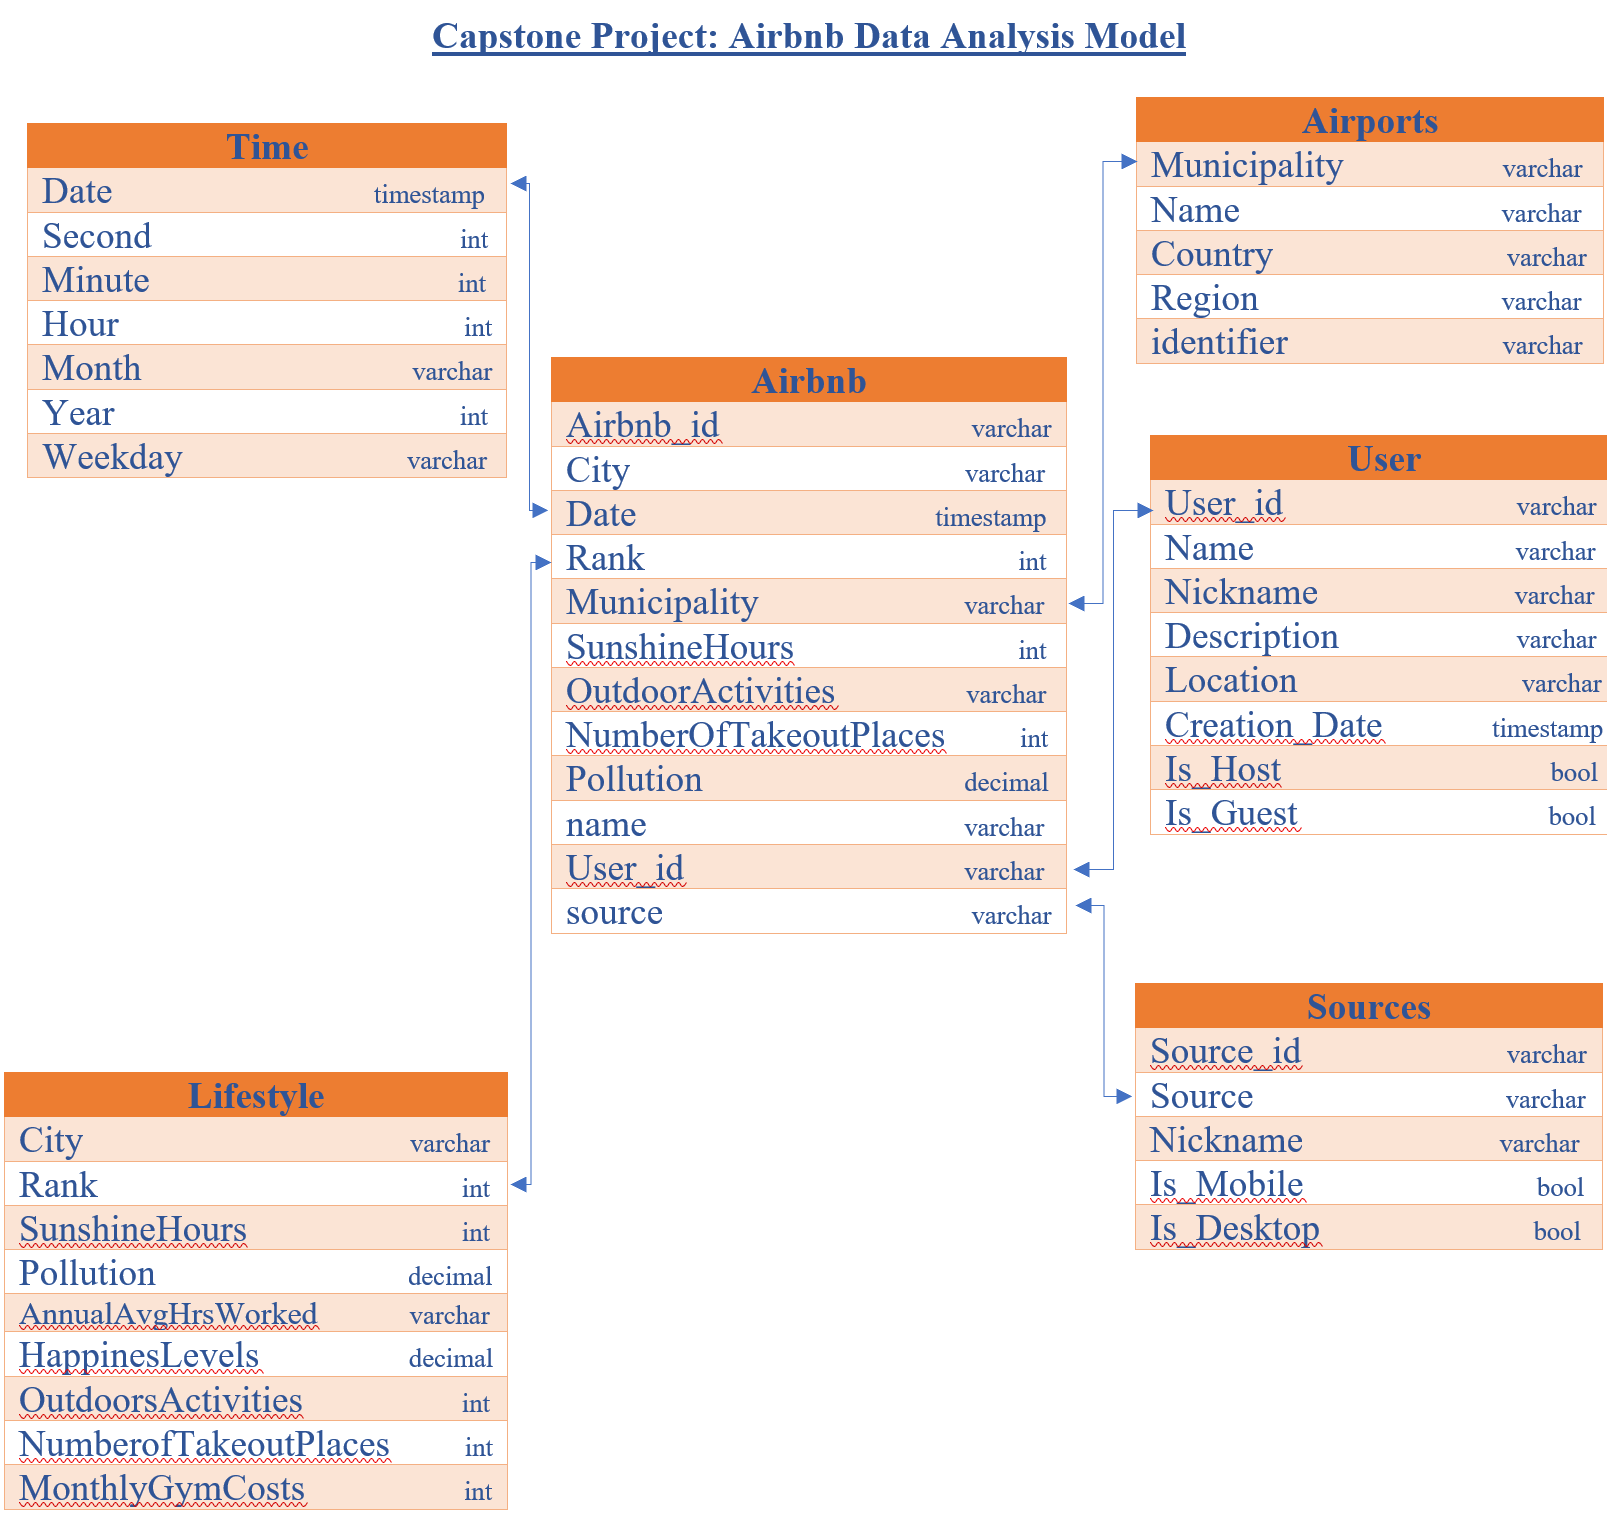

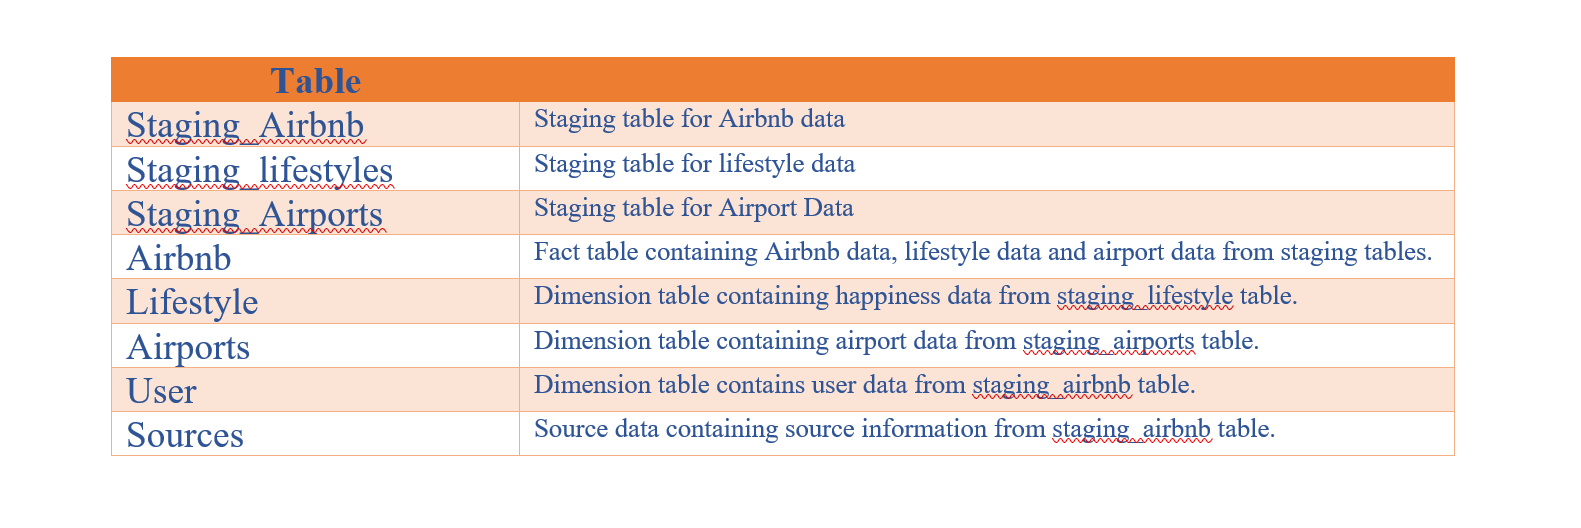

In [25]:
import IPython.display as display
from PIL import Image

display.display(Image.open('images/Datamodel.png'))
display.display(Image.open('images/tabledescriptions.png'))

##### The Star Database Schema (Fact and Dimension Schema) is used for data modeling in this ETL pipeline. There is one fact table containing all the metrics (facts) associated to each tweet and five dimensions tables, containing associated information such as user, source etc. This model enables to search the database schema with the minimum number of *SQL JOIN*s possible and enable fast read queries

# Data dictionary

## About
This file contains an overview of the attributes (columns), types and descriptions for all tables used in the project.

### Tables

#### Staging Airbnb

| Column | Type | Description |
| --- | --- | --- |
| Airbnb_id | VARCHAR | ID of Airbnb|
| City | VARCHAR | Destination City of Airbnb |
| Municipality | VARCHAR | Destination Municipality of Airbnb |
| AirportName | VARCHAR | Airport Name within Municipality and City of Airbnb |
| Rank | INT | Lifestyle Ranking of City where Airbnb is located |
| Date | INT | Date Airbnb booked or searched for |
| SunshineHours | INT |Number of hours City or Municipality where Airbnb is located has Sunshine |
| OutdoorActivities | INT | Number of outdoor Activities in which City/Municipality where Airbnb is located has to offer |
| NumberOfTakeOutPlaces | INT | Number of Restaurants City/Municipality where Airbnb is located has to offer |
| PollutionIndex | DECIMAL | Amount of Pollution City/Municipality where Airbnb experiences|
| User_ID | VARCHAR | ID of Airbnb User |
| source | VARCHAR | Device/App used to book Airbnb, ex:  Android/iPhone,  Desktop, etc.|


#### Staging Lifestyles

| Column | Type | Description |
| --- | --- | --- |
| City | VARCHAR | Name of City |
| Rank | INT | Lifestyle Ranking of City where Airbnb is located |
| SunshineHours | INT | Number of hours City or Municipality where Airbnb is located has Sunshine|
| ObesityLevelsPercentage | DECIMAL | Obesity Rate of people living within City where AIRBNB is located |
| PollutionIndex | DECIMAL | Lower bound of confidence Interval for happiness score |
| AverageAnnualHoursWorked | DECIMAL | Contribution of economic situation to happiness score|
| HappinessLevels | DECIMAL | Contribution of family situation to happiness score|
| OutdoorActivities | DECIMAL | Contribution of life expectancy to happiness score|
| freedom | DECIMAL | Contribution of personal/collective freedom to happiness score|
| NumberOfTakeOutPlaces | DECIMAL | Contribution of corruption into situation to happiness score |
| MonthlyGymMembershipCostEuros | DECIMAL | Contribution of perceived generosity to happiness score|


#### Staging Airports

| Column | Type | Description |
| --- | --- | --- |
|Municipality | VARCHAR | Date when the temperature was recorded|
|Name | VARCHAR | Average temperature measured at recording date|
|Country | VARCHAR | 95% confidence interval around average temperature |
|Region | VARCHAR | Country where temperature was recorded|
|Identifier | VARCHAR | Country where temperature was recorded|

#### Users
| Column | Type | Description |
| --- | --- | --- |
| User_id | VARCHAR | ID of Airbnb User |
| name | VARCHAR | Actual name of Airbnb user, ex: "Nathan Wohner" |
| nickname | VARCHAR | Screen name of the Airbnb user, ex: @TimeTravelorsHusband |
| description | VARCHAR | Bio of the Airbnb user |
| location | VARCHAR | Location of Airbnb user, ex: France, Austria |
| creation_date | TIMESTAMP | Date when the Airbnb user was created |
| is_host | BOOL | Whether the user is an Airbnb host |
| is_guest | BOOL | Whether the user is an Airbnb guest |

#### Sources
| Column | Type | Description |
| --- | --- | --- |
|source_id | BIGINT | Auto-incrementing ID of sources|
|source | VARCHAR | Device/App used to book Airbnb, ex: Android/iPhone, Desktop, etc. |
|is_mobile | BOOL | Whether the source is a mobile device|
|is_desktop | BOOL | Whether the source is made by Airbnb|

#### Lifestyles
| Column | Type | Description |
| --- | --- | ---|
| City | VARCHAR | Name of the city aribnb is located |
| rank | INT | Lifestyle ranking within city airbnb is located |
| SunshineHours | INT | Number of day hours within city Airbnb is located |
| ObesityLevelsPercentage | DECIMAL | Obesity rate within city where Airbnb is located |
| PollutionIndex | DECIMAL | Pollution levels within city where Airbnb is located |
| AverageAnnualHoursWorked | INT | Average annual hours employees work in city where Airbnb is located |
| HappinessLevels | DECIMAL | Contribution of personal/collective freedom to happiness score |
| OutdoorActivities | INT | Contribution of corruption into situation to happiness score |
| NumberOfTakeOutPlaces | INT | Number of restaurants in city where Airbnb is located |
| MonthlyGymMembershipCostEuros | DECIMAL | Average cost of gym membership in City where Aribnb is located |

#### Airports
| Column | Type | Description |
| --- | --- | ---|
| Municipality | VARCHAR | Municipality of airport |
| Name | VARCHAR | Name of airport|
| Country | VARCHAR | Country of Airport|
| Region | VARCHAR | Region of Airport|
| Identifier | VARCHAR | Unique identifier of airport|

#### Time
| Column | Type | Description |
| --- | --- | ---|
| date | TIMESTAMP | Union of distinct TIMESTAMPs from user_date and tweet_date found in staging_tweets|
| second | INT | Second derived from date|
| minute | INT | Minute derived from date|
| hour | INT | Hour derived from date|
| month | VARCHAR | Month derived from date|
| year | INT | Year derived from date|
| weekday | VARCHAR | Weekday derived from date|

#### Airbnb
| Column | Type | Description |
| --- | --- | ---|
| Airbnb_id | VARCHAR | ID of tweet |
| City | VARCHAR | Sentiment of the tweet text as determined by AWS Comprehend (positive/neutral/negative) |
| Municipality | VARCHAR | Text of tweet |
| AirportName | IN | Number of times the tweet is marked as favorite by other Twitter users |
| Rank | INT | Lifestyle ranking within city airbnb is located |
| Date | TIMESTAMP | Date when tweet was created |
| SunshineHours | INT | Number of day hours within city Airbnb is located |
| OutdoorActivities | INT | Contribution of corruption into situation to happiness score |
| NumberOfTakeOutPlaces | INT | Number of restaurants in city where Airbnb is located |
| PollutionIndex | DECIMAL | Pollution levels within city where Airbnb is located |
| User_id | VARCHAR | ID of Airbnb User |
|source | VARCHAR | Device/App used to book Airbnb, ex: Android/iPhone, Desktop, etc. |


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

### How to run

Follow the steps to extract and load the data into the data model.

1. Set up Apache Airflow

2. Navigate to `Capstone Project` folder

3. Install requirements by

   

4. Edit and fill in `config.cfg` as per requirements

5. Download the static datasets into [datasets](./datasets) directory

6. Trigger Airflow DAG ON

7. Verify the DAG execution by executing analytics tasks.


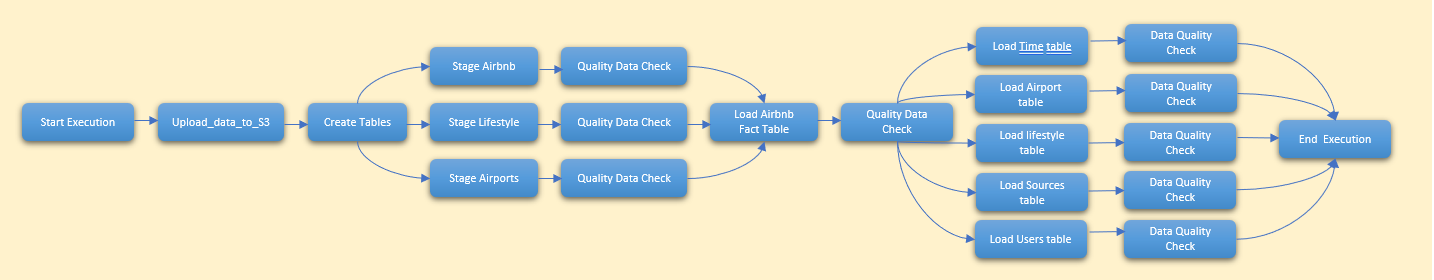

In [2]:
import IPython.display as display
from PIL import Image

display.display(Image.open('images/airflowdiagram.png'))

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.